# Defesa ou ataque?

O objetivo desse estudo é descobrir, qual dos fatores impacta mais no futebol: uma melhor defesa ou melhor ataque?

## Dataframe

Antes de mais nada, o primeiro passo a ser feito é "ler" todos os dataframes dentro do código!

In [79]:
import pandas as pd
import os

partidas = pd.read_csv(os.getcwd() + '/data/results.csv', parse_dates=['date'], dayfirst=True)
goals = pd.read_csv(os.getcwd() + '/data/goalscorers.csv', parse_dates=['date'], dayfirst=True)
shootouts = pd.read_csv(os.getcwd() + '/data/shootouts.csv', parse_dates=['date'], dayfirst=True)

partidas.set_index('date', inplace=True)
partidas.head()

,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date,,,,,,,,
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


### Manipulação de dados

Agora, antes de realizar as análises, vamos criar uma variável com o resultado da partida (usando o time da casa como referência):

In [80]:
import numpy as np

resultado = []

for _, row in partidas.iterrows():
    if row['home_score'] > row['away_score']:
        resultado.append('vitoria')
    elif row['home_score'] < row['away_score']:
        resultado.append('derrota')
    else:
        resultado.append('empate')

partidas['resultado'] = resultado

Agora, vamos criar uma nova variável que guarda a quantidade total de gols na partida. Esse dado vai ser usado mais tarde!

In [81]:
partidas['gols'] = partidas['home_score'] + partidas['away_score']

Além disso, irão ser agrupadas em um novo dataframe as seguintes informações
- Time da casa
- Quantidade de resultados do time da casa (vitória e derrota)

In [82]:
selecoes_home = partidas.groupby(['home_team','resultado']).count()['country'].sort_values(ascending=False).reset_index().rename(columns={'country': 'partidas', 'home_team': 'time_casa'})
selecoes_home.head()

,time_casa,resultado,partidas
0,Brazil,vitoria,426
1,Argentina,vitoria,376
2,Germany,vitoria,327
3,Mexico,vitoria,326
4,England,vitoria,326


Além disso, irão ser agrupadas em um novo dataframe as seguintes informações
- Time fora de casa
- Quantidade de resultados do time fora de casa (vitória e derrota)

In [83]:
selecoes_away=partidas.groupby(['away_team','resultado']).count()['country'].sort_values(ascending=False).reset_index().rename(columns={'country': 'partidas', 'away_team': 'time_fora'})
selecoes_away.replace({'derrota': 'vitoria', 'vitoria':'derrota'}, inplace=True) ## uma derrota pro time da casa é uma vitória pro time que joga fora
selecoes_away.head()

,time_fora,resultado,partidas
0,England,vitoria,271
1,Finland,derrota,252
2,Germany,vitoria,247
3,Uruguay,derrota,233
4,Brazil,vitoria,228


Adicionando algumas propriedades a esse dataframe, ao final vamos ter um dataframe com, por time, a quantidade de vitorias e derrotas, e quanto isso representa do total. Considerando o time como jogando em casa!

In [84]:
# Contando quantas partidas cada time jogou em casa
partidas_em_casa=[]
for team in selecoes_home['time_casa']:
    total_jogado_casa = selecoes_home[selecoes_home['time_casa']== team]['partidas'].sum()
    partidas_em_casa.append(total_jogado_casa)
   
selecoes_home['partidas_casa'] = partidas_em_casa
selecoes_home['%_total_casa'] = selecoes_home['partidas']/selecoes_home['partidas_casa']

selecoes_home.rename(columns={'resultado': 'home_resultados', 'partidas': 'home_partidas'}, inplace=True)
selecoes_home.set_index('time_casa', inplace=True)

selecoes_home.head()

,home_resultados,home_partidas,partidas_casa,%_total_casa
time_casa,,,,
Brazil,vitoria,426,594,0.717172
Argentina,vitoria,376,570,0.659649
Germany,vitoria,327,526,0.621673
Mexico,vitoria,326,555,0.587387
England,vitoria,326,525,0.620952


Adicionando algumas propriedades a esse dataframe, ao final vamos ter um dataframe com, por time, a quantidade de vitorias e derrotas, e quanto isso representa do total. Considerando o time como jogando fora de casa!

In [85]:
# Contando quantas partidas cada time jogou fora de casa
partidas_fora=[]
for team in selecoes_away['time_fora']:
    total_jogado_fora = selecoes_away[selecoes_away['time_fora'] == team]['partidas'].sum()
    partidas_fora.append(total_jogado_fora)

selecoes_away['partidas_fora']= partidas_fora
selecoes_away['%_total_fora'] = selecoes_away['partidas']/selecoes_away['partidas_fora']

selecoes_away.rename(columns={'resultado': 'away_resultados', 'partidas': 'away_partidas'}, inplace=True)
selecoes_away.set_index('time_fora', inplace=True)

selecoes_away.head()

,away_resultados,away_partidas,partidas_fora,%_total_fora
time_fora,,,,
England,vitoria,271,524,0.517176
Finland,derrota,252,433,0.581986
Germany,vitoria,247,460,0.536957
Uruguay,derrota,233,560,0.416071
Brazil,vitoria,228,427,0.533958


Agrupando todas as vitórias em casa/fora e derrotas em casa/fora, temos:

In [86]:
home_winners= selecoes_home[selecoes_home['home_resultados'] == 'vitoria']
home_losers= selecoes_home[selecoes_home['home_resultados'] =='derrota']
away_winners= selecoes_away[selecoes_away['away_resultados'] =='vitoria']
away_losers= selecoes_away[selecoes_away['away_resultados'] =='derrota']

In [87]:
winners=pd.merge(home_winners, away_winners, left_index=True, right_index=True, how='inner')
winners.rename(columns={'%_total_casa': '%_casa_vitorias', '%_total_fora': '%_fora_vitorias'}, inplace=True)

losers=pd.merge(home_losers, away_losers, left_index=True, right_index=True, how='inner')
losers.rename(columns={'%_total_casa': '%_casa_derrotas', '%_total_fora': '%_fora_derrotas'}, inplace=True)

In [88]:
winners

,home_resultados,home_partidas,partidas_casa,%_casa_vitorias,away_resultados,away_partidas,partidas_fora,%_fora_vitorias
Brazil,vitoria,426,594,0.717172,vitoria,228,427,0.533958
Argentina,vitoria,376,570,0.659649,vitoria,175,448,0.390625
Germany,vitoria,327,526,0.621673,vitoria,247,460,0.536957
Mexico,vitoria,326,555,0.587387,vitoria,151,380,0.397368
England,vitoria,326,525,0.620952,vitoria,271,524,0.517176
...,...,...,...,...,...,...,...,...
Chameria,vitoria,1,1,1.000000,vitoria,1,4,0.250000
South Ossetia,vitoria,1,7,0.142857,vitoria,3,7,0.428571
Matabeleland,vitoria,1,2,0.500000,vitoria,2,6,0.333333
Biafra,vitoria,1,2,0.500000,vitoria,1,1,1.000000


In [89]:
winners['total_vitorias']= winners['home_partidas'] + winners['away_partidas']
winners['total']= winners['partidas_casa'] + winners['partidas_fora']

winners['%_vitorias']= winners['total_vitorias']/winners['total']
winners_pct= winners[['%_casa_vitorias', '%_fora_vitorias', '%_vitorias']]

In [90]:
winners_pct.head()

,%_casa_vitorias,%_fora_vitorias,%_vitorias
Brazil,0.717172,0.533958,0.640548
Argentina,0.659649,0.390625,0.541257
Germany,0.621673,0.536957,0.582150
Mexico,0.587387,0.397368,0.510160
England,0.620952,0.517176,0.569113


In [91]:
losers

,home_resultados,home_partidas,partidas_casa,%_casa_derrotas,away_resultados,away_partidas,partidas_fora,%_fora_derrotas
Luxembourg,derrota,172,239,0.719665,derrota,160,193,0.829016
Finland,derrota,162,345,0.469565,derrota,252,433,0.581986
Malta,derrota,147,238,0.617647,derrota,150,189,0.793651
Northern Ireland,derrota,144,325,0.443077,derrota,202,348,0.580460
Norway,derrota,141,415,0.339759,derrota,195,419,0.465394
...,...,...,...,...,...,...,...,...
County of Nice,derrota,1,4,0.250000,derrota,1,5,0.200000
Sark,derrota,1,1,1.000000,derrota,3,3,1.000000
Vatican City,derrota,1,2,0.500000,derrota,3,4,0.750000
Kabylia,derrota,1,1,1.000000,derrota,2,5,0.400000


In [92]:
losers['total_derrotas']= losers['home_partidas'] + losers['away_partidas']
losers['total']= losers['partidas_casa'] + losers['away_partidas']

losers['%_derrotas']= losers['total_derrotas']/losers['total']
losers_pct= losers[['%_casa_derrotas', '%_fora_derrotas', '%_derrotas']]

In [93]:
losers_pct

,%_casa_derrotas,%_fora_derrotas,%_derrotas
Luxembourg,0.719665,0.829016,0.832080
Finland,0.469565,0.581986,0.693467
Malta,0.617647,0.793651,0.765464
Northern Ireland,0.443077,0.580460,0.656546
Norway,0.339759,0.465394,0.550820
...,...,...,...
County of Nice,0.250000,0.200000,0.400000
Sark,1.000000,1.000000,1.000000
Vatican City,0.500000,0.750000,0.800000
Kabylia,1.000000,0.400000,1.000000


In [18]:
#total percentage
winners_pct.sort_values(by='%_vitorias', ascending=False)
winners_pct=np.round(winners_pct*100, 2)
winners_pct['tot_count']= winners.tot_count
winners_pct['tot_matches']= winners.tot_matches

In [94]:
winners_pct

,%_casa_vitorias,%_fora_vitorias,%_vitorias
Brazil,0.717172,0.533958,0.640548
Argentina,0.659649,0.390625,0.541257
Germany,0.621673,0.536957,0.582150
Mexico,0.587387,0.397368,0.510160
England,0.620952,0.517176,0.569113
...,...,...,...
Chameria,1.000000,0.250000,0.400000
South Ossetia,0.142857,0.428571,0.285714
Matabeleland,0.500000,0.333333,0.375000
Biafra,0.500000,1.000000,0.666667


In [20]:
losers_pct=np.round(losers_pct*100, 2)
losers_pct['tot_count']= losers.tot_count
losers_pct['tot_matches']= losers.tot_matches

In [21]:
losers_pct

,pct_home_defeats,pct_away_defeats,tot_pct_defeats,tot_count,tot_matches
Luxembourg,71.97,82.90,76.85,332,432
Finland,46.96,58.20,53.21,414,778
Malta,61.76,79.37,69.56,297,427
Northern Ireland,44.31,58.05,51.41,346,673
Norway,33.98,46.54,40.29,336,834
...,...,...,...,...,...
Montenegro,29.58,50.77,39.71,54,136
Central African Republic,38.18,79.59,57.69,60,104
Afghanistan,38.10,56.96,50.41,61,121
Turkmenistan,25.86,59.77,46.21,67,145


In [22]:
winners_pct.sort_values(by='tot_pct_victory', ascending=False)

,pct_home_victory,pct_victory_away,tot_pct_victory,tot_count,tot_matches
Brazil,71.72,53.40,64.05,654,1021
Germany,62.17,53.70,58.22,574,986
Spain,67.81,47.74,58.12,426,733
England,62.10,51.72,56.91,597,1049
Iran,63.27,45.89,55.62,292,525
...,...,...,...,...,...
Seychelles,22.64,4.23,12.10,15,124
Luxembourg,11.72,7.77,9.95,43,432
Somalia,13.33,5.97,8.93,10,112
Liechtenstein,9.43,5.88,7.56,17,225


In [23]:
winners_pct.to_csv('export.csv')

In [24]:
#discover goal and history

home_matches=partidas.groupby('time_da_casa').sum().rename(columns={'gols_casa': 'goals_scored_home', 'gols_fora' : 'goals_taken_home'})

away_matches=partidas.groupby('time_fora_casa').sum().rename(columns={'gols_casa': 'goals_taken_away', 'gols_fora' : 'goals_scored_away'})

#merging 

score= pd.merge(home_matches, away_matches, how='inner', right_index= True, left_index=True)

#creating calculated fields
score['tot_goals_scored']= score['goals_scored_home'] + score['goals_scored_away']
score['tot_goals_taken']= score['goals_taken_home'] + score['goals_taken_away']
score['diff_goals_tot'] = score['tot_goals_scored'] - score['tot_goals_taken']
#score.drop(columns=['neutral_x', 'goals_x', 'neutral_y', 'goals_y'], inplace=True)

#get the match count (only teams with 100 match played are taken)
score=pd.merge(score, winners[['home_matches', 'away_matches', 'tot_matches']], how='inner', right_index=True, left_index=True)

#compute ratios
score['home_goals_pct'] = score['goals_scored_home']/ score['home_matches']
score['away_goals_pct'] = score['goals_scored_away']/ score['away_matches']
score['home_goals_taken_pct'] = score['goals_taken_home']/ score['home_matches']
score['away_goals_taken_pct'] = score['goals_taken_away']/ score['away_matches']
score['tot_goals_scored_pct'] = score['tot_goals_scored']/ score['tot_matches']
score['tot_goals_taken_pct'] = score['tot_goals_taken']/ score['tot_matches']
score_pct= score[['home_goals_pct', 'away_goals_pct', 'home_goals_taken_pct', 'away_goals_taken_pct',
                 'tot_goals_scored_pct', 'tot_goals_taken_pct', 'diff_goals_tot']]

score_pct.sort_values(by='diff_goals_tot', ascending=False)

#join winners with score

total_ratio= pd.merge(score_pct, winners_pct, how='inner', right_index=True, left_index=True)
total_ratio= pd.merge(total_ratio, losers_pct, how='inner', right_index=True, left_index=True)

score_pct.sort_values(by='diff_goals_tot', ascending=False)

correlation= total_ratio[['tot_goals_scored_pct', 'tot_goals_taken_pct', 
                          'tot_pct_victory','tot_pct_defeats']].corr()

<AxesSubplot: >

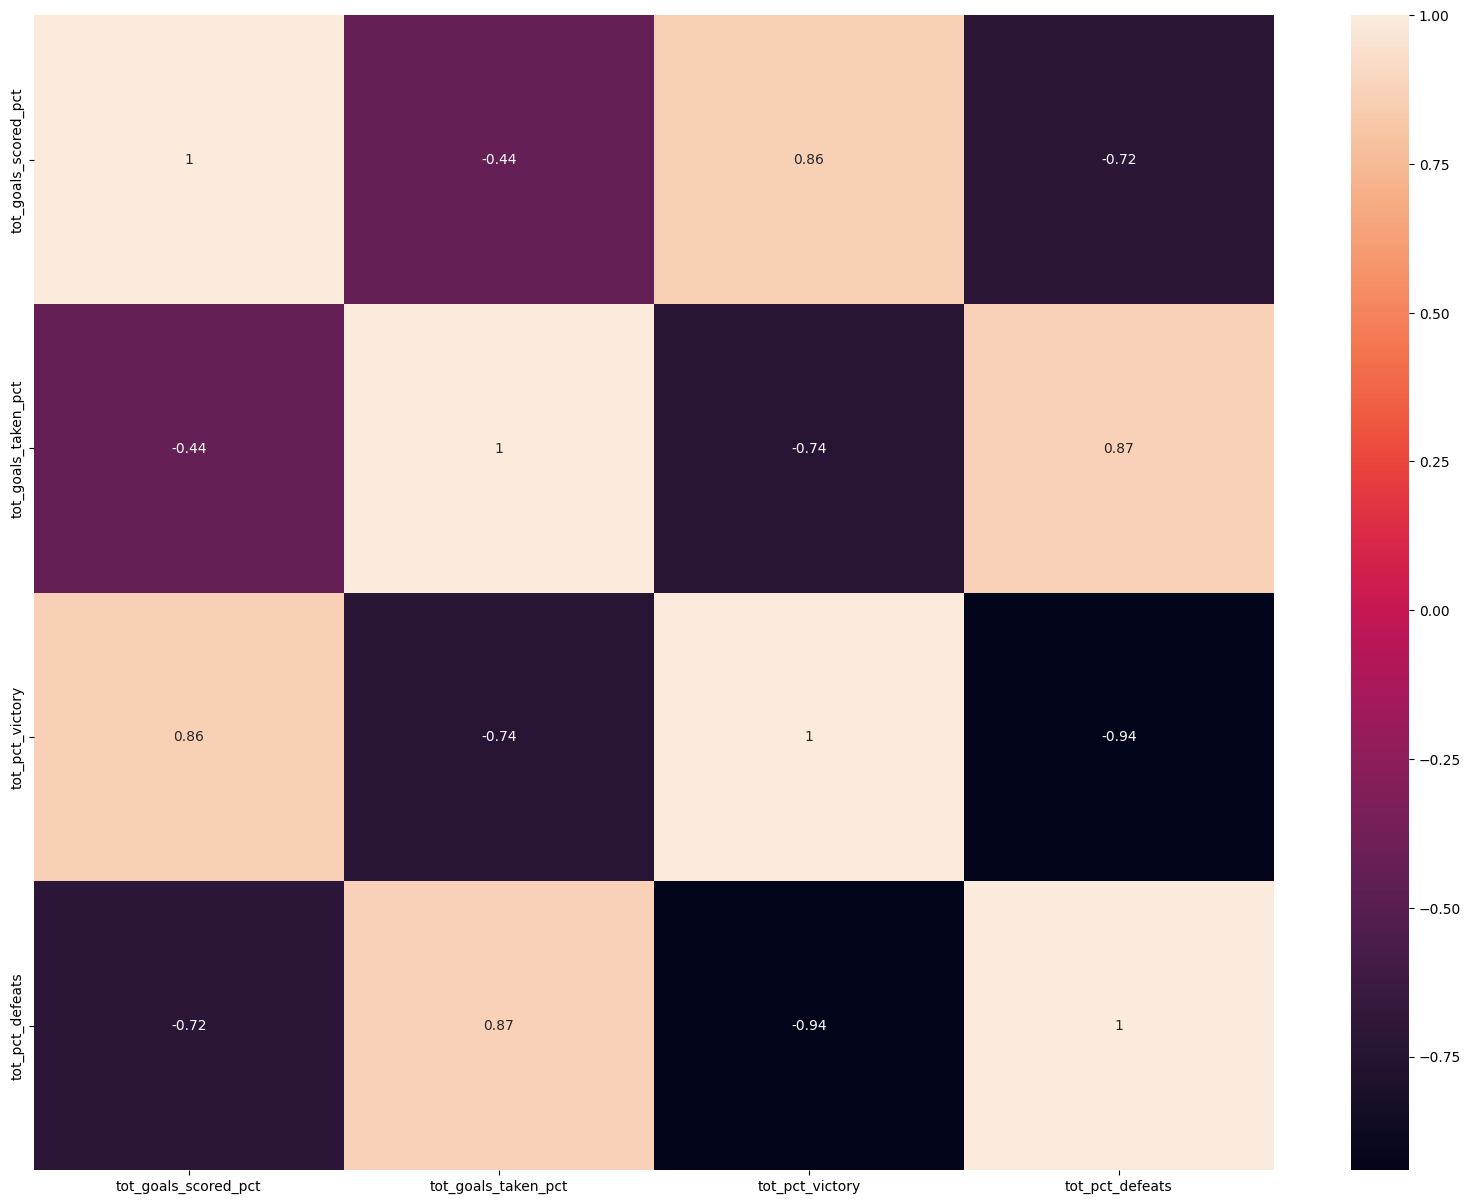

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,15))
sns.heatmap(correlation, annot=True)